In [1]:
import torch
class ScaledConjugateGradient(torch.optim.Optimizer):
    def __init__(self, params, sigma=1e-4, lambda_=1e-6, lambdaHAT=0, N=10):
        params = list(params) 
        if len(params) == 0:
            raise ValueError("No parameters were passed to the optimizer.")
        defaults = {'sigma': sigma, 'lambda': lambda_, 'lambdaHAT': lambdaHAT, 'N': N}
        super(ScaledConjugateGradient, self).__init__(params, defaults)
        self.k = 1
        self.sigma = sigma
        self.N = sum(p.numel() for p in params)
        self.state = {}
        flattened_params = self.flattendTheModelParameters()
        self.state['rHat'] = torch.zeros_like(flattened_params)
        self.state['pHat'] = torch.zeros_like(flattened_params)
        self.state['lambda'] = lambda_
        self.state['lambdaHAT'] = lambdaHAT
        self.state['delta_k'] = 0
        self.state['success'] = True

    def flattendTheModelParameters(self):
        params = []
        for group in self.param_groups:
            for p in group['params']:
                if p.requires_grad:
                    params.append(p.view(-1))  
        return torch.cat(params) 

    def reshapeModelParams(self, flattened_params):
        offset = 0
        for group in self.param_groups:
            for p in group['params']:
                numel = p.numel() 
                p.data.copy_(flattened_params[offset:offset + numel].view_as(p))
                offset += numel

    def computeTheModelGradients(self, closure):
        loss = closure()
        flattened_grad = self.flattendTheModelGradients()
        return loss, flattened_grad

    def flattendTheModelGradients(self):
        grads = []
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    grads.append(p.grad.view(-1)) 
        return torch.cat(grads) 

    def step(self, closure=None):
        state = self.state
        N = self.N
        loss, grad = self.computeTheModelGradients(closure)
        state['rHat'].copy_(-grad)  
        state['pHat'].copy_(state['rHat'])
        pHat_norm = torch.norm(state['pHat'])
        if state['success'] == True:
            sigma_k = self.sigma / pHat_norm
            old_params = self.flattendTheModelParameters()
            new_params = self.flattendTheModelParameters() + sigma_k * state['pHat']
            self.reshapeModelParams(new_params)
            new_loss, new_grad = self.computeTheModelGradients(closure)
            self.reshapeModelParams(old_params)
            s_k = (new_grad - grad) / sigma_k
            delta_k = torch.dot(state['pHat'], s_k)
            state['delta_k'] = delta_k  
        state['delta_k'] = state['delta_k'] + (state['lambda'] - state['lambdaHAT']) * (pHat_norm**2)
        if state['delta_k'] <= 0:
            state['lambdaHAT'] = 2 * (state['lambda'] - (state['delta_k'] /pHat_norm**2))
            state['delta_k'] = -state['delta_k'] + state['lambda'] * pHat_norm**2
            state['lambda'] = state['lambdaHAT']
        mu_k = torch.dot(state['pHat'], state['rHat'])
        alpha_k = mu_k / state['delta_k'] + 1e-10
        old_params = self.flattendTheModelParameters()
        new_params = self.flattendTheModelParameters() + alpha_k * state['pHat']
        self.reshapeModelParams(new_params)
        new_loss, new_grad = self.computeTheModelGradients(closure)
        self.reshapeModelParams(old_params)
        delta_k_placeholder = 2 * state['delta_k'] * (loss - new_loss) / (mu_k**2)
        old_rHat = state['rHat']
        if delta_k_placeholder >= 0:
            self.reshapeModelParams(new_params)
            state['rHat'] = -new_grad
            state['lambdaHAT'] = 0
            state['success'] = True
            if self.k % N == 0:
                state['pHat'] = state['rHat']
            else:
                beta_k = (torch.norm(state['rHat'])**2 - torch.dot(state['rHat'], old_rHat))/mu_k
                state['pHat'] = state['rHat'] + beta_k*state['pHat']
            if delta_k_placeholder >= 0.75:
                state['lambda'] /= 4
        else:
            state['lambdaHAT'] = state['lambda']
            state['success'] = False
        if delta_k_placeholder < 0.25:
            state['lambda'] += (state['delta_k'] * (1 - delta_k_placeholder)/ pHat_norm**2)
        if torch.allclose(old_rHat, torch.zeros_like(old_rHat)):
            return loss
        else:
            self.k +=1

In [2]:
import numpy as np
import torch
import math
import torch.nn as nn

class LeapFrogOptimizer:
  def __init__(self, model, loss_function, dt, delta, epsilon, DeltaOne, m, max_iteration):
    self.model = model
    self.s = 1
    self.p = 1
    self.x = torch.cat([p.detach().clone().flatten() for p in model.parameters()])
    self.x_prev = self.x.clone() 
    self.x_next = self.x.clone() 
    self.a = torch.zeros(param_size)       
    self.x_next_next = self.x.clone() 
    self.loss_function = loss_function 
    self.k = -1
    self.dt = dt 
    self.a_next = torch.zeros(param_size) 
    self.delta = delta 
    self.epsilon = epsilon
    self.m = m 
    self.DeltaOne = DeltaOne
    self.max_iteration = max_iteration 
    self.v = torch.zeros(param_size)    
    self.i = 0
    self.j = 2
 
    param_size = self.x.size(0)
    self.v_prev = torch.zeros(param_size) 
    self.v_next = torch.zeros(param_size)

  def calculateGradientsofParams(self, X, y):
      self.model.zero_grad() 
      predictions = self.model(X) 
      loss = self.loss_function(predictions, y)
      loss.backward() 
      gradients = -torch.cat([p.grad.clone().flatten() for p in self.model.parameters()])

      return gradients

  def step(self, X, y):
    self.a = self.calculateGradientsofParams(X, y)
    self.v = 0.5 * self.a * self.dt

    while self.k < self.max_iteration:
      self.k += 1
      dx_norm = torch.norm(self.v) * self.dt
      if dx_norm < self.delta:                             
        self.p += self.DeltaOne 
        self.dt *= self.p
      else:
        self.v = (self.delta * self.v)/(self.dt * torch.norm(self.v))

      if self.s >= self.m:                                    
        self.dt /= 2 
        self.x = (self.x + self.x_prev)/2
        self.v = (self.v + self.v_prev)/4
        self.s = 0
      self.x_next = self.x + (self.v * self.dt)
             
      with torch.no_grad():
            predictions = self.model(X)
            current_loss = self.loss_function(predictions, y)
            print(f'Epoch {self.k}, Loss: {current_loss.item()}')
      while True:
        with torch.no_grad():
            start_idx = 0
            for param in self.model.parameters():
              param_size = param.numel()
              end_idx = start_idx + param_size
              param_values = self.x_next[start_idx:end_idx].reshape(param.shape)
              param.copy_(param_values)
              start_idx = end_idx
        self.a_next = self.calculateGradientsofParams(X, y)
        self.v_next = self.v + self.a_next * self.dt
        if torch.dot(self.a_next, self.a) > 0:
          self.s = 0
        else:
          self.s += 1
          self.p = 1

        if torch.norm(self.a_next) <= self.epsilon:
          print("Optimization converged.")
          return

        if torch.norm(self.v_next) > torch.norm(self.v):
          self.i = 0
          break
        else:
          self.x_next_next = (self.x_next + self.x)/2
          self.i += 1 

        if self.i <= self.j:
          self.v_next = (self.v_next + self.v)/4
          self.k += 1 
        else:
          self.v_next = torch.zeros_like(self.v)
          self.j = 1
          self.k += 1
        if torch.norm(self.v_next) > torch.norm(self.v):
          break
      
        self.x_prev = self.x.clone()
        self.x = self.x_next.clone()
        self.x_next = self.x_next_next.clone()
        self.v_prev = self.v.clone()
        self.v = self.v_next.clone()
        self.a = self.a_next.clone()
   
      self.x_prev = self.x.clone()
      self.x = self.x_next.clone()
      self.x_next = self.x_next_next.clone()
      self.v_prev = self.v.clone()
      self.v = self.v_next.clone()
      self.a = self.a_next.clone()

Using device: cuda
Fitting 10 folds for each of 8 candidates, totalling 80 fits
Optimal parameters: {'activation': 'tanh', 'hidden_size': 64}
Best MSE score: 0.262582785928373
   param_hidden_size param_activation  mean_test_score
0                 64             tanh        -0.262583
1                128             tanh        -0.275256
2                256             tanh        -0.295773
3                512             tanh        -0.313182
4                 64             relu        -1.009724
5                128             relu        -1.005000
6                256             relu        -1.021508
7                512             relu        -1.042719


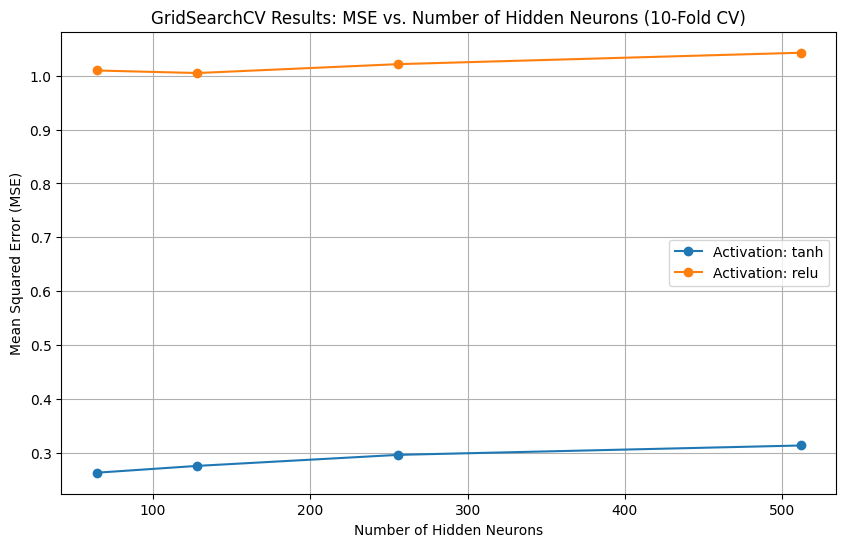

In [31]:
from sklearn.base import BaseEstimator, RegressorMixin  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from torch.optim import Adam
from torch.utils.data import TensorDataset
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation='tanh'):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.activation = activation

    def forward(self, x):
        if self.activation == 'tanh':
            x = torch.tanh(self.hidden(x))
        elif self.activation == 'leakyrelu':
            x = nn.functional.leaky_relu(self.hidden(x))
        else:  
            x = self.hidden(x)
        x = self.output(x)
        return x


def target_function(x1, x2):
    return np.sin(x1) * np.cos(x2) + np.log(x1**2 + x2**2 + 1)


num_samples = 2500
x1_data = np.random.uniform(-100, 100, num_samples)
x2_data = np.random.uniform(-100, 100, num_samples)


y_data = target_function(x1_data, x2_data)


X_data = np.column_stack((x1_data, x2_data))


num_train_samples = int(0.5 * num_samples)  
num_val_samples = int(0.25 * num_samples)   
num_test_samples = num_samples - num_train_samples - num_val_samples  

X_train = X_data[:num_train_samples]
y_train = y_data[:num_train_samples]

X_val = X_data[num_train_samples:num_train_samples + num_val_samples]
y_val = y_data[num_train_samples:num_train_samples + num_val_samples]

X_test = X_data[num_train_samples + num_val_samples:]
y_test = y_data[num_train_samples + num_val_samples:]


scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_train_standardized = scaler_x.fit_transform(X_train)
y_train_standardized = scaler_y.fit_transform(y_train.reshape(-1, 1))


X_val_standardized = scaler_x.transform(X_val)
y_val_standardized = scaler_y.transform(y_val.reshape(-1, 1))

X_test_standardized = scaler_x.transform(X_test)
y_test_standardized = scaler_y.transform(y_test.reshape(-1, 1))


X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_standardized, dtype=torch.float32).to(device)


class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size=2, hidden_size=1, output_size=1, activation='tanh', epochs=50, batch_size=128, lr=0.01):
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        self.device = device
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size, self.activation).to(self.device)

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size, self.activation).to(self.device)
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(self.device),
                                torch.tensor(y, dtype=torch.float32).to(self.device))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        self.model.train()
        for epoch in range(self.epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            return self.model(X_tensor).cpu().numpy()


X_train_np = X_train_standardized
y_train_np = y_train_standardized


param_grid = {
    'hidden_size': [64, 128, 256, 512],
    'activation': ['tanh', 'relu']
}


grid_search = GridSearchCV(
    estimator=PyTorchRegressor(input_size=2, epochs=50, batch_size=256, lr=0.01),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=2,
    n_jobs=-1
)


grid_search.fit(X_train_np, y_train_np)

optimal_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Optimal parameters: {optimal_params}")
print(f"Best MSE score: {best_score}")


results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_hidden_size', 'param_activation', 'mean_test_score']])


plt.figure(figsize=(10, 6))
for activation in param_grid['activation']:
    subset = results_df[results_df['param_activation'] == activation]
    plt.plot(subset['param_hidden_size'], -subset['mean_test_score'], marker='o', linestyle='-', label=f'Activation: {activation}')

plt.title('GridSearchCV Results: MSE vs. Number of Hidden Neurons (10-Fold CV)')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


----

Using device: cuda
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Optimal parameters: {'lr': 0.005, 'momentum': 0.05}
Best MSE score: 0.2947692572739279
   param_lr  param_momentum  mean_test_score
0     0.001            0.00        -0.338361
1     0.001            0.05        -0.341777
2     0.001            0.10        -0.322587
3     0.005            0.00        -0.299338
4     0.005            0.05        -0.294769
5     0.005            0.10        -0.300079
6     0.010            0.00        -0.365250
7     0.010            0.05        -0.311845
8     0.010            0.10        -0.297469


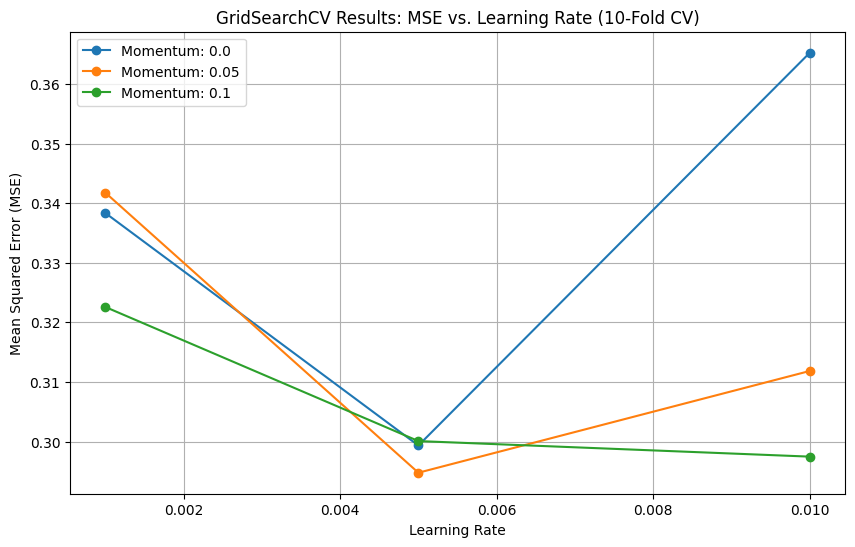

In [43]:
from sklearn.base import BaseEstimator, RegressorMixin  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from torch.optim import SGD  
from torch.utils.data import TensorDataset
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

np.random.seed(42)
torch.manual_seed(42)

import torch.nn as nn
import torch

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()  

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)
        return x



def target_function(x1, x2):
    return np.sin(x1) * np.cos(x2) + np.log(x1**2 + x2**2 + 1)


num_samples = 1000
x1_data = np.random.uniform(-10, 10, num_samples)
x2_data = np.random.uniform(-10, 10, num_samples)


y_data = target_function(x1_data, x2_data)


X_data = np.column_stack((x1_data, x2_data))


num_train_samples = int(num_samples)
X_train = X_data[:num_train_samples]
y_train = y_data[:num_train_samples]


scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_train_standardized = scaler_x.fit_transform(X_train)
y_train_standardized = scaler_y.fit_transform(y_train.reshape(-1, 1))


X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_standardized, dtype=torch.float32).to(device)

batch_size = 1  


class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size=2, hidden_size=1, output_size=1, epochs=50, batch_size=1, lr=0.01, momentum=0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.momentum = momentum
        self.device = device
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)

    def fit(self, X, y):
        
        self.model = SimpleNN(self.input_size, self.hidden_size, self.output_size).to(self.device)
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(self.device),
                                torch.tensor(y, dtype=torch.float32).to(self.device))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        criterion = nn.MSELoss()

        self.model.train()
        for epoch in range(self.epochs):
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            return self.model(X_tensor).cpu().numpy()


X_train_np = X_train_standardized
y_train_np = y_train_standardized


param_grid = {
    'lr': [0.001,0.005, 0.01],        
    'momentum': [0.0, 0.05,0.1],  
}


grid_search = GridSearchCV(estimator=PyTorchRegressor(input_size=2, hidden_size=64, epochs=5, batch_size=1),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=10, verbose=2, n_jobs=-1)


grid_search.fit(X_train_np, y_train_np)


optimal_params = grid_search.best_params_
best_score = -grid_search.best_score_  

print(f"Optimal parameters: {optimal_params}")
print(f"Best MSE score: {best_score}")


results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_lr', 'param_momentum', 'mean_test_score']])


plt.figure(figsize=(10, 6))
for momentum in param_grid['momentum']:
    subset = results_df[results_df['param_momentum'] == momentum]
    plt.plot(subset['param_lr'], -subset['mean_test_score'], marker='o', linestyle='-', label=f'Momentum: {momentum}')

plt.title('GridSearchCV Results: MSE vs. Learning Rate (10-Fold CV)')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


Optimal parameters: {'lr': 0.005, 'momentum': 0.05}
Best MSE score: 0.2947692572739279
   param_lr  param_momentum  mean_test_score
0     0.001            0.00        -0.338361
1     0.001            0.05        -0.341777
2     0.001            0.10        -0.322587
3     0.005            0.00        -0.299338
4     0.005            0.05        -0.294769
5     0.005            0.10        -0.300079
6     0.010            0.00        -0.365250
7     0.010            0.05        -0.311845
8     0.010            0.10        -0.297469


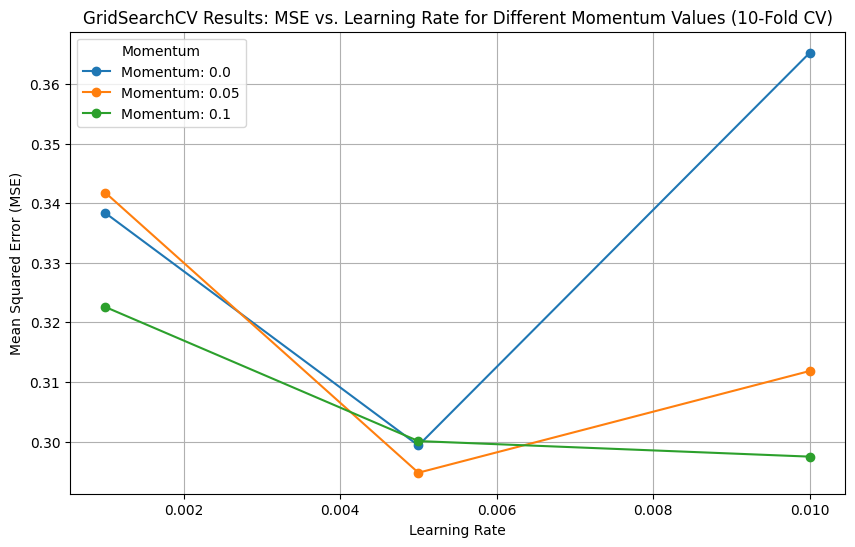

In [44]:

import matplotlib.pyplot as plt


optimal_params = grid_search.best_params_
best_score = -grid_search.best_score_  

print(f"Optimal parameters: {optimal_params}")
print(f"Best MSE score: {best_score}")


results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_lr', 'param_momentum', 'mean_test_score']])


plt.figure(figsize=(10, 6))


momentum_values = results_df['param_momentum'].unique()
for momentum in momentum_values:
    subset = results_df[results_df['param_momentum'] == momentum]
    plt.plot(subset['param_lr'], -subset['mean_test_score'], marker='o', linestyle='-', label=f'Momentum: {momentum}')


plt.title('GridSearchCV Results: MSE vs. Learning Rate for Different Momentum Values (10-Fold CV)')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(title='Momentum')
plt.grid(True)
plt.show()


Using device: cuda
KFold(n_splits=10, random_state=42, shuffle=True)

Training fold 1/10...
Epoch 1/10:
Average Training Loss for Epoch 1: 0.920905

Epoch 2/10:
Average Training Loss for Epoch 2: 0.539708

Epoch 3/10:
Average Training Loss for Epoch 3: 0.351487

Epoch 4/10:
Average Training Loss for Epoch 4: 0.320531

Epoch 5/10:
Average Training Loss for Epoch 5: 0.304052

Epoch 6/10:
Average Training Loss for Epoch 6: 0.302215

Epoch 7/10:
Average Training Loss for Epoch 7: 0.298646

Epoch 8/10:
Average Training Loss for Epoch 8: 0.295704

Epoch 9/10:
Average Training Loss for Epoch 9: 0.282992

Epoch 10/10:
Average Training Loss for Epoch 10: 0.295665

Fold 1 - Test Loss: 0.250481, Training Time: 27.73 seconds

Training fold 2/10...
Epoch 1/10:
Average Training Loss for Epoch 1: 0.877585

Epoch 2/10:
Average Training Loss for Epoch 2: 0.534492

Epoch 3/10:
Average Training Loss for Epoch 3: 0.359285

Epoch 4/10:
Average Training Loss for Epoch 4: 0.320986

Epoch 5/10:
Average Traini

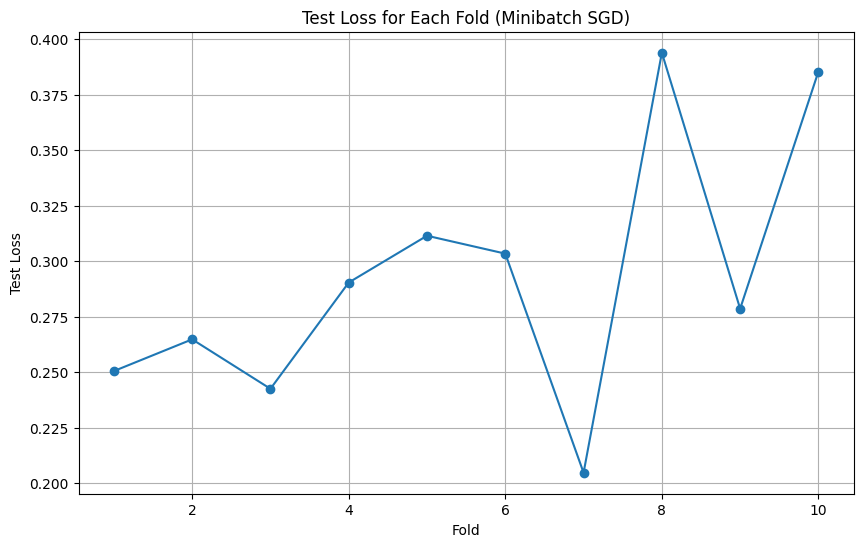


Training Times for Each Fold:
Fold 1: 27.73 seconds
Fold 2: 26.38 seconds
Fold 3: 27.58 seconds
Fold 4: 26.16 seconds
Fold 5: 25.05 seconds
Fold 6: 23.09 seconds
Fold 7: 20.90 seconds
Fold 8: 20.93 seconds
Fold 9: 20.80 seconds
Fold 10: 21.10 seconds


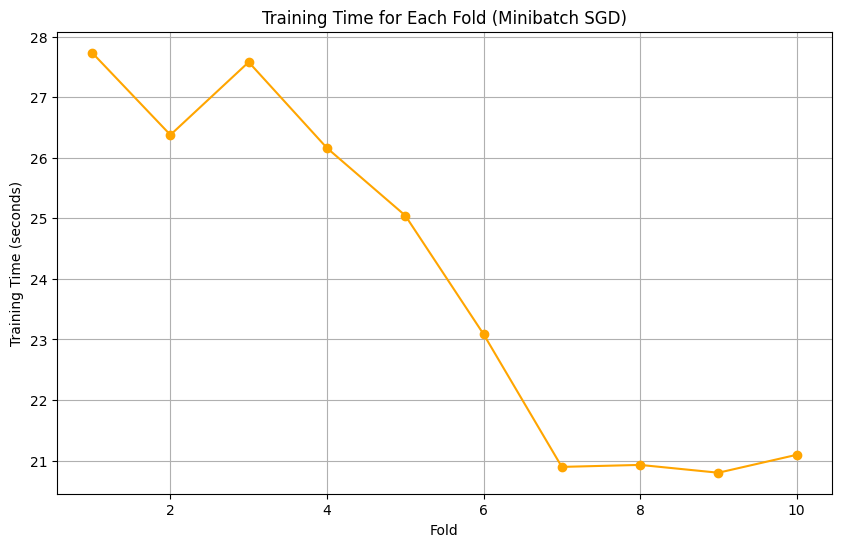

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


np.random.seed(42)
torch.manual_seed(42)


def target_function(x1, x2):
    return np.sin(x1) * np.cos(x2) + np.log(x1**2 + x2**2 + 1)


num_samples = 1000
x1_data = np.random.uniform(-10, 10, num_samples)
x2_data = np.random.uniform(-10, 10, num_samples)


y_data = target_function(x1_data, x2_data)


X_data = np.column_stack((x1_data, x2_data))


scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_data_standardized = scaler_x.fit_transform(X_data)
y_data_standardized = scaler_y.fit_transform(y_data.reshape(-1, 1))




class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()  

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)
        return x


def train_model_minibatch(model, X_train, y_train, num_epochs=10, lr=0.1, batch_size=256, momentum = 0.5):
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    train_losses = []

    
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    start_time = time.time()  
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        print(f"Epoch {epoch+1}/{num_epochs}:")  

        for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            
            train_loss += loss.item() * batch_X.size(0)

        train_loss /= len(train_dataset)  
        train_losses.append(train_loss)
        
        print(f"Average Training Loss for Epoch {epoch+1}: {train_loss:.6f}\n")  
    end_time = time.time()  
    training_time = end_time - start_time  

    return train_losses, training_time


def cross_validate_model(X, y, num_folds=10, num_epochs=10, lr=0.005, batch_size=256, momentum = 0.05):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []
    print(kf)
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")

        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        np.random.seed(42 + fold)
        torch.manual_seed(42 + fold)
        
        model = SimpleNN(input_size=2, hidden_size=64, output_size=1).to(device)

        
        train_losses, training_time = train_model_minibatch(
            model, X_train, y_train, num_epochs=num_epochs, lr=lr, batch_size=batch_size, momentum = momentum
        )

        
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
            test_loss = nn.MSELoss()(model(X_test_tensor), y_test_tensor).item()

        
        fold_results.append({
            'fold': fold + 1,
            'loss': test_loss,
            'training_time': training_time
        })

        print(f"Fold {fold+1} - Test Loss: {test_loss:.6f}, Training Time: {training_time:.2f} seconds")

    return fold_results


cross_val_results = cross_validate_model(
    x_data_standardized, y_data_standardized, num_folds=10, num_epochs=10, lr=0.005, batch_size=1, momentum  = 0.05
)


cross_val_df_sgd = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_sgd)


test_losses = [result['loss'] for result in cross_val_results]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', label='Test Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Fold (Minibatch SGD)')
plt.grid(True)
plt.show()


training_times = [result['training_time'] for result in cross_val_results]
print("\nTraining Times for Each Fold:")
for i, t in enumerate(training_times):
    print(f"Fold {i+1}: {t:.2f} seconds")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_times) + 1), training_times, marker='o', color='orange', label='Training Time per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold (Minibatch SGD)')
plt.grid(True)
plt.show()


Using device: cuda

Training fold 1/10...
SCG - Epoch 1/10, Train Loss: 1.002213
SCG - Epoch 2/10, Train Loss: 0.961424
SCG - Epoch 3/10, Train Loss: 0.923799
SCG - Epoch 4/10, Train Loss: 0.904564
SCG - Epoch 5/10, Train Loss: 0.886558
SCG - Epoch 6/10, Train Loss: 0.875000
SCG - Epoch 7/10, Train Loss: 0.863325
SCG - Epoch 8/10, Train Loss: 0.851547
SCG - Epoch 9/10, Train Loss: 0.839502
SCG - Epoch 10/10, Train Loss: 0.827297
Fold 1 - Test Loss: 0.678725, Training Time: 0.19 seconds

Training fold 2/10...
SCG - Epoch 1/10, Train Loss: 0.983746
SCG - Epoch 2/10, Train Loss: 0.975282
SCG - Epoch 3/10, Train Loss: 0.967259
SCG - Epoch 4/10, Train Loss: 0.959385
SCG - Epoch 5/10, Train Loss: 0.951632
SCG - Epoch 6/10, Train Loss: 0.943968
SCG - Epoch 7/10, Train Loss: 0.936359
SCG - Epoch 8/10, Train Loss: 0.928788
SCG - Epoch 9/10, Train Loss: 0.921213
SCG - Epoch 10/10, Train Loss: 0.913634
Fold 2 - Test Loss: 1.014771, Training Time: 0.14 seconds

Training fold 3/10...
SCG - Epoch 1/

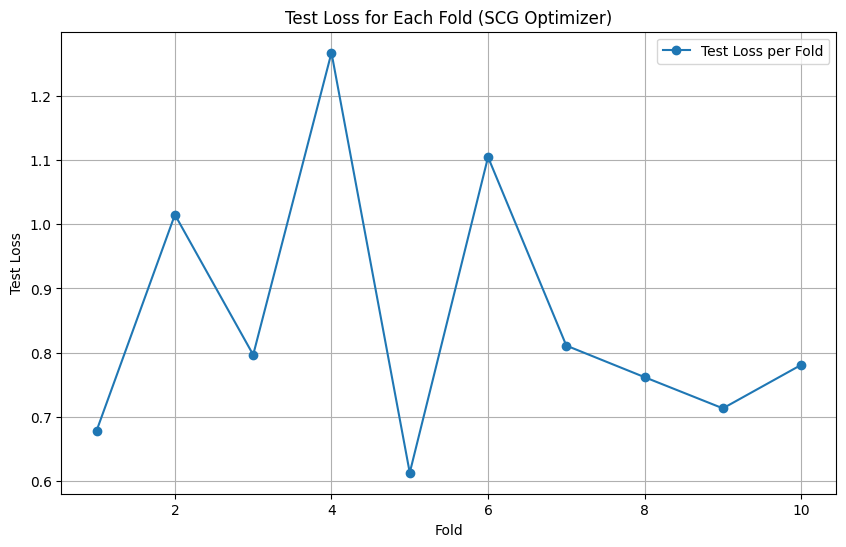


Training Times for Each Fold:
Fold 1: 0.19 seconds
Fold 2: 0.14 seconds
Fold 3: 0.11 seconds
Fold 4: 0.07 seconds
Fold 5: 0.12 seconds
Fold 6: 0.13 seconds
Fold 7: 0.14 seconds
Fold 8: 0.12 seconds
Fold 9: 0.13 seconds
Fold 10: 0.12 seconds


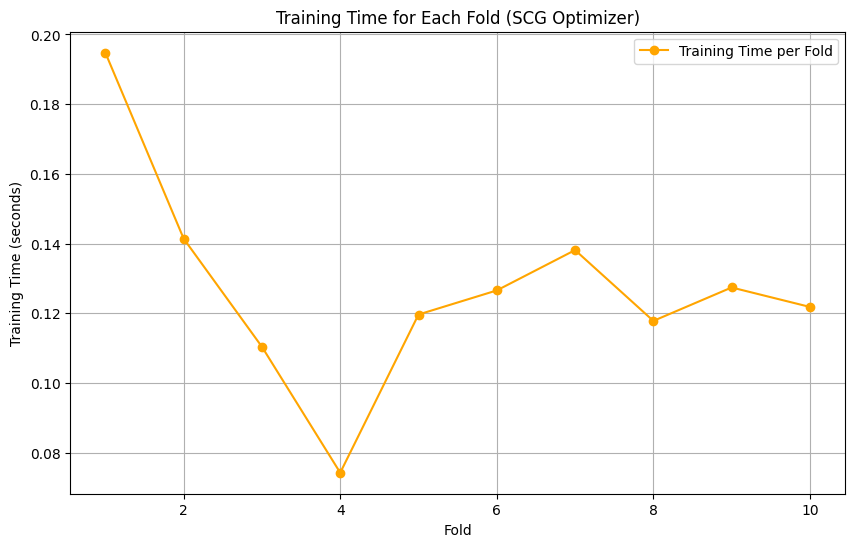

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
import pandas as pd





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


np.random.seed(42)
torch.manual_seed(42)


def target_function(x1, x2):
    return np.sin(x1) * np.cos(x2) + np.log(x1**2 + x2**2 + 1)


num_samples = 1000
x1_data = np.random.uniform(-10, 10, num_samples)
x2_data = np.random.uniform(-10, 10, num_samples)


y_data = target_function(x1_data, x2_data)


X_data = np.column_stack((x1_data, x2_data))


scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_data_standardized = scaler_x.fit_transform(X_data)
y_data_standardized = scaler_y.fit_transform(y_data.reshape(-1, 1))


X_data_tensor = torch.tensor(x_data_standardized, dtype=torch.float32).to(device)
y_data_tensor = torch.tensor(y_data_standardized, dtype=torch.float32).to(device)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  
        self.output = nn.Linear(hidden_size, output_size)  
        self.tanh = nn.Tanh()  

    def forward(self, x):
        x = self.tanh(self.hidden(x))  
        x = self.output(x)  
        return x


def train_model_scg(model, X_train, y_train, num_epochs=50):
    criterion = nn.MSELoss()
    optimizer = ScaledConjugateGradient(model.parameters(), sigma=1e-4, lambda_=1e-6, lambda_hat=0, N=10)
    train_losses = []

    
    def closure():
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        return loss

    start_time = time.time()  
    for epoch in range(num_epochs):
        model.train()
        optimizer.step(closure)
        train_loss = criterion(model(X_train), y_train).item()
        train_losses.append(train_loss)
        print(f"SCG - Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}")
    end_time = time.time()  
    training_time = end_time - start_time  

    return train_losses, training_time


def cross_validate_model(X, y, num_folds=10, num_epochs=50):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")

        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        np.random.seed(42 + fold)
        torch.manual_seed(42 + fold)

        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

        
        model = SimpleNN(input_size=2, hidden_size=32, output_size=1).to(device)

        
        train_losses, training_time = train_model_scg(model, X_train_tensor, y_train_tensor, num_epochs=num_epochs)

        
        model.eval()
        with torch.no_grad():
            test_output = model(X_test_tensor)
            test_loss = nn.MSELoss()(test_output, y_test_tensor).item()

        
        fold_results.append({
            'fold': fold + 1,
            'loss': test_loss,
            'training_time': training_time
        })

        print(f"Fold {fold+1} - Test Loss: {test_loss:.6f}, Training Time: {training_time:.2f} seconds")

    return fold_results


cross_val_results = cross_validate_model(
    x_data_standardized, y_data_standardized, num_folds=10, num_epochs=10
)


cross_val_df_scg = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_scg)


test_losses = [result['loss'] for result in cross_val_results]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', label='Test Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Fold (SCG Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


training_times = [result['training_time'] for result in cross_val_results]
print("\nTraining Times for Each Fold:")
for i, t in enumerate(training_times):
    print(f"Fold {i+1}: {t:.2f} seconds")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_times) + 1), training_times, marker='o', color='orange', label='Training Time per Fold')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold (SCG Optimizer)')
plt.grid(True)
plt.legend()
plt.show()


Using device: cuda

Training fold 1/10...
Epoch 0, Loss: 17.424049377441406
Epoch 1, Loss: 6.874100208282471
Epoch 2, Loss: 1.593456506729126
Epoch 3, Loss: 4.93656587600708
Epoch 5, Loss: 1.5023335218429565
Epoch 7, Loss: 1.2425892353057861
Epoch 8, Loss: 1.1662408113479614
Epoch 10, Loss: 1.149472951889038
LeapFrog - Epoch 0, Train Loss: 1.1429
Fold 1 - Test Loss: 0.968112, Training Time: 0.09 seconds

Training fold 2/10...
Epoch 0, Loss: 17.899030685424805
Epoch 1, Loss: 6.985115051269531
Epoch 2, Loss: 1.3678756952285767
Epoch 3, Loss: 6.010082721710205
Epoch 5, Loss: 1.6821078062057495
Epoch 7, Loss: 1.1469658613204956
Epoch 8, Loss: 1.1332578659057617
Epoch 10, Loss: 1.1257988214492798
LeapFrog - Epoch 0, Train Loss: 1.1094
Fold 2 - Test Loss: 1.208938, Training Time: 0.07 seconds

Training fold 3/10...
Epoch 0, Loss: 18.665708541870117
Epoch 1, Loss: 7.667491436004639
Epoch 2, Loss: 1.6157158613204956
Epoch 3, Loss: 5.472161769866943
Epoch 5, Loss: 1.5518076419830322
Epoch 7, Lo

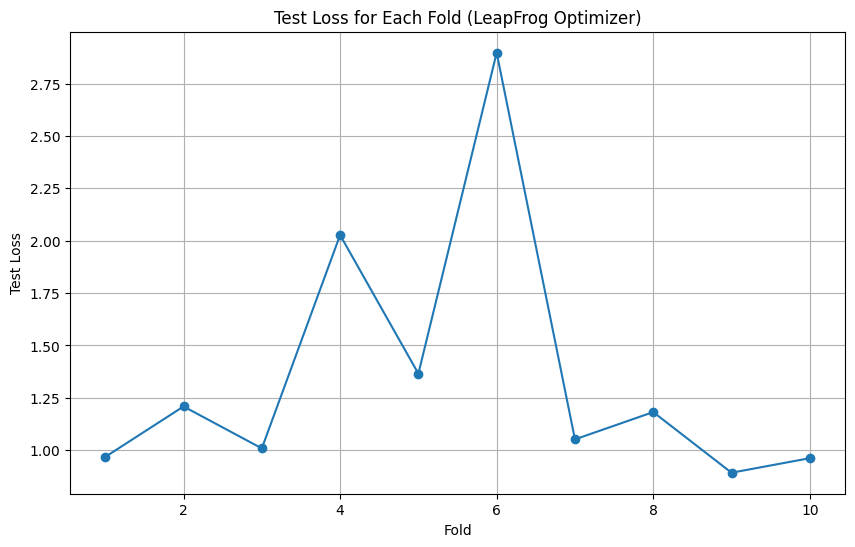


Training Times for Each Fold:
Fold 1: 0.09 seconds
Fold 2: 0.07 seconds
Fold 3: 0.08 seconds
Fold 4: 0.07 seconds
Fold 5: 0.08 seconds
Fold 6: 0.07 seconds
Fold 7: 0.07 seconds
Fold 8: 0.08 seconds
Fold 9: 0.07 seconds
Fold 10: 0.07 seconds


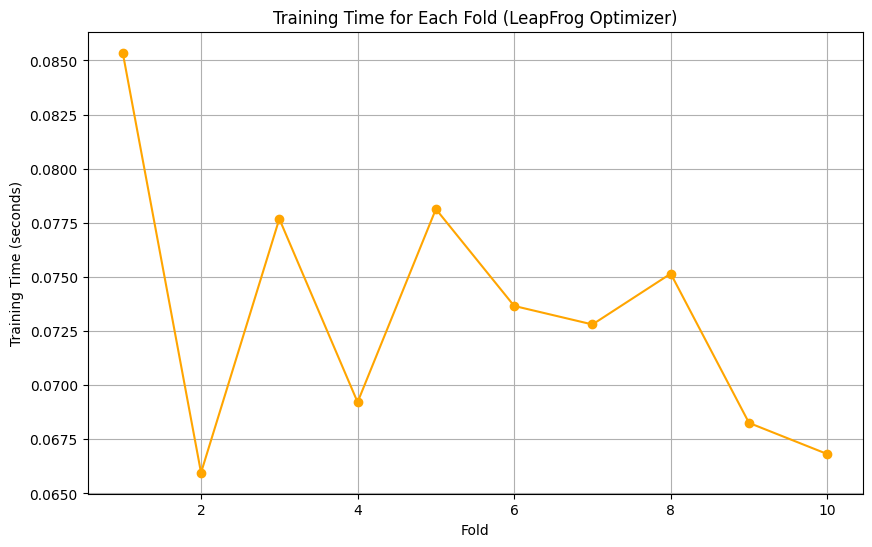

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import time
import pandas as pd




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


np.random.seed(42)
torch.manual_seed(42)


def target_function(x1, x2):
    return np.sin(x1) * np.cos(x2) + np.log(x1**2 + x2**2 + 1)


num_samples = 1000
x1_data = np.random.uniform(-10, 10, num_samples)
x2_data = np.random.uniform(-10, 10, num_samples)


y_data = target_function(x1_data, x2_data)


X_data = np.column_stack((x1_data, x2_data))


scaler_x = StandardScaler()
X_data_standardized = scaler_x.fit_transform(X_data)


y_data = y_data.reshape(-1, 1)  


X_data_tensor = torch.tensor(X_data_standardized, dtype=torch.float32).to(device)
y_data_tensor = torch.tensor(y_data, dtype=torch.float32).to(device)


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.hidden(x)  
        x = self.output(x)
        return x


def train_model_leapfrog(model, X_train, y_train, num_epochs=100, patience=10):
    criterion = nn.MSELoss()
    optimizer = LeapFrogOptimizer(model, criterion, dt=0.5, delta=1, epsilon=1e-7, delta1=0.1, m=3, max_iteration=num_epochs)
    train_losses = []
    patience_counter = 0  
    best_train_loss = float('inf')
    best_model_state = None

    
    start_time = time.time()

    for epoch in range(num_epochs):
        
        optimizer.step(X_train, y_train)

        
        model.train()
        output_train = model(X_train)
        train_loss = criterion(output_train, y_train).item()
        train_losses.append(train_loss)

        
        if train_loss < best_train_loss:
            best_train_loss = train_loss
            best_model_state = model.state_dict()
            patience_counter = 0  
        else:
            patience_counter += 1  

        
        if epoch % 10 == 0:
            print(f"LeapFrog - Epoch {epoch}, Train Loss: {train_loss:.4f}")

        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    
    end_time = time.time()
    training_time = end_time - start_time

    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    else:
        print("No improvement during training")

    return train_losses, training_time


def cross_validate_model(X, y, num_folds=10, num_epochs=100, patience=10):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nTraining fold {fold+1}/{num_folds}...")

        
        np.random.seed(42 + fold)
        torch.manual_seed(42 + fold)

        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        model = SimpleNN(input_size=2, hidden_size=10, output_size=1).to(device)

        
        train_losses, training_time = train_model_leapfrog(
            model, X_train, y_train, num_epochs=num_epochs, patience=patience
        )

        
        model.eval()
        with torch.no_grad():
            test_loss = nn.MSELoss()(model(X_test), y_test).item()
        
        fold_results.append({
            'fold': fold + 1,
            'loss': test_loss,
            'training_time': training_time
        })

        print(f"Fold {fold+1} - Test Loss: {test_loss:.6f}, Training Time: {training_time:.2f} seconds")

    return fold_results


cross_val_results = cross_validate_model(
    X_data_tensor, y_data_tensor, num_folds=10, num_epochs=10, patience=100
)


cross_val_df_leapFrog = pd.DataFrame(cross_val_results)
print("\nCross-Validation Results:")
print(cross_val_df_leapFrog)


test_losses = [result['loss'] for result in cross_val_results]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses)+1), test_losses, marker='o')
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title('Test Loss for Each Fold (LeapFrog Optimizer)')
plt.grid(True)
plt.show()


training_times = [result['training_time'] for result in cross_val_results]
print("\nTraining Times for Each Fold:")
for i, t in enumerate(training_times):
    print(f"Fold {i+1}: {t:.2f} seconds")


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_times)+1), training_times, marker='o', color='orange')
plt.xlabel('Fold')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Each Fold (LeapFrog Optimizer)')
plt.grid(True)
plt.show()


In [7]:
cross_val_df_leapFrog
cross_val_df_scg
cross_val_df_sgd

,fold,loss,training_time
0,1,0.250481,27.732786
1,2,0.264774,26.376118
2,3,0.242492,27.578148
3,4,0.290370,26.159765
4,5,0.311453,25.045270
5,6,0.303389,23.087032
6,7,0.204682,20.895854
7,8,0.393908,20.928560
8,9,0.278568,20.799640
9,10,0.385432,21.095341


In [8]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

loss_leapfrog = cross_val_df_leapFrog['loss'].values
loss_scg = cross_val_df_scg['loss'].values
loss_sgd = cross_val_df_sgd['loss'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})

In [9]:

statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)


Friedman test statistic: 20.0
p-value: 4.539992976248486e-05


In [10]:
if p_value < 0.05:
    print('Result: There is a statistically significant difference between the optimizers.')
else:
    print('Result: There is no statistically significant difference between the optimizers.')


Result: There is a statistically significant difference between the optimizers.


In [11]:

nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)


nemenyi_results.columns = ['LeapFrog', 'SCG', 'SGD']
nemenyi_results.index = ['LeapFrog', 'SCG', 'SGD']

print('\nNemenyi post-hoc test p-values:')
print(nemenyi_results)



Nemenyi post-hoc test p-values:
          LeapFrog       SCG       SGD
LeapFrog  1.000000  0.065303  0.001000
SCG       0.065303  1.000000  0.065303
SGD       0.001000  0.065303  1.000000


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from tabulate import tabulate  







loss_leapfrog = cross_val_df_leapFrog['loss'].values
loss_scg = cross_val_df_scg['loss'].values
loss_sgd = cross_val_df_sgd['loss'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})


statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print('\nResult: There is a statistically significant difference between the optimizers.')

    
    nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)

    
    nemenyi_results.columns = ['LeapFrog', 'SCG', 'SGD']
    nemenyi_results.index = ['LeapFrog', 'SCG', 'SGD']

    
    nemenyi_results = nemenyi_results.round(5)

    
    print('\nNemenyi post-hoc test p-values:')
    print(tabulate(nemenyi_results, headers='keys', tablefmt='grid'))
else:
    print('\nResult: There is no statistically significant difference between the optimizers.')


Friedman test statistic: 20.0
p-value: 4.539992976248486e-05

Result: There is a statistically significant difference between the optimizers.

Nemenyi post-hoc test p-values:
+----------+------------+--------+--------+
|          |   LeapFrog |    SCG |    SGD |
+==========+============+========+========+
| LeapFrog |     1      | 0.0653 | 0.001  |
+----------+------------+--------+--------+
| SCG      |     0.0653 | 1      | 0.0653 |
+----------+------------+--------+--------+
| SGD      |     0.001  | 0.0653 | 1      |
+----------+------------+--------+--------+


Friedman test statistic: 20.0
p-value: 4.539992976248486e-05

Result: There is a statistically significant difference between the optimizers.

Nemenyi post-hoc test p-values:
+----------+------------+--------+--------+
|          |   LeapFrog |    SCG |    SGD |
+==========+============+========+========+
| LeapFrog |     1      | 0.0653 | 0.001  |
+----------+------------+--------+--------+
| SCG      |     0.0653 | 1      | 0.0653 |
+----------+------------+--------+--------+
| SGD      |     0.001  | 0.0653 | 1      |
+----------+------------+--------+--------+

Interpretation of the Table:
Diagonal Elements: The diagonal elements are all 1, as they represent comparisons of each optimizer with itself.

Significant P-Values (p < 0.05):
- LeapFrog vs. SGD: p = 0.001 (significant)

Non-Significant P-Values (p >= 0.05):
- LeapFrog vs. SCG: p = 0.0653 (not significant)
- SCG vs. SGD: p = 0.0653 (not significant)


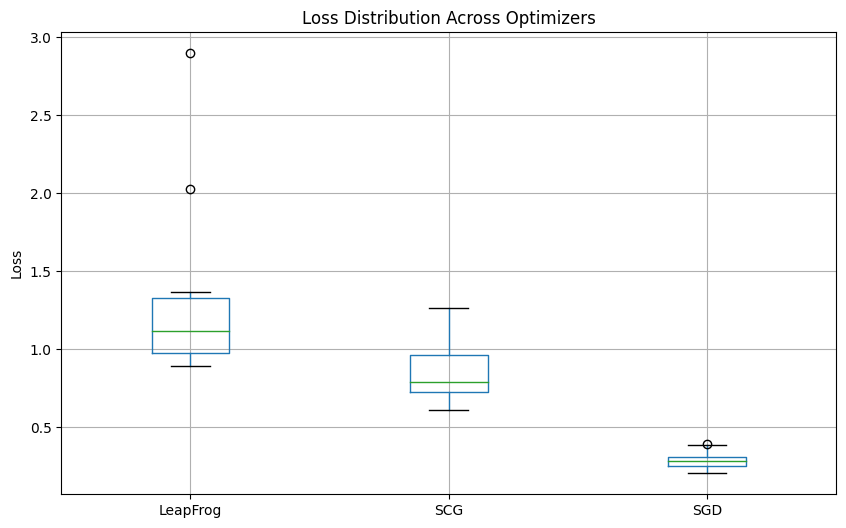

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from tabulate import tabulate  







loss_leapfrog = cross_val_df_leapFrog['loss'].values
loss_scg = cross_val_df_scg['loss'].values
loss_sgd = cross_val_df_sgd['loss'].values


combined_losses = pd.DataFrame({
    'LeapFrog': loss_leapfrog,
    'SCG': loss_scg,
    'SGD': loss_sgd
})


statistic, p_value = friedmanchisquare(
    combined_losses['LeapFrog'],
    combined_losses['SCG'],
    combined_losses['SGD']
)

print('Friedman test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print('\nResult: There is a statistically significant difference between the optimizers.')

    
    nemenyi_results = sp.posthoc_nemenyi_friedman(combined_losses.values)

    
    optimizers = combined_losses.columns.tolist()
    nemenyi_results.columns = optimizers
    nemenyi_results.index = optimizers

    
    nemenyi_results = nemenyi_results.round(5)

    
    print('\nNemenyi post-hoc test p-values:')
    print(tabulate(nemenyi_results, headers='keys', tablefmt='grid'))

    
    print('\nInterpretation of the Table:')
    print('Diagonal Elements: The diagonal elements are all 1, as they represent comparisons of each optimizer with itself.\n')

    significant_pairs = []
    nonsignificant_pairs = []
    alpha = 0.05  

    
    for i in range(len(optimizers)):
        for j in range(i + 1, len(optimizers)):
            optimizer1 = optimizers[i]
            optimizer2 = optimizers[j]
            p_val = nemenyi_results.iloc[i, j]
            if p_val < alpha:
                significant_pairs.append((optimizer1, optimizer2, p_val))
            else:
                nonsignificant_pairs.append((optimizer1, optimizer2, p_val))

    
    if significant_pairs:
        print('Significant P-Values (p < 0.05):')
        for opt1, opt2, p_val in significant_pairs:
            print(f'- {opt1} vs. {opt2}: p = {p_val} (significant)')
    else:
        print('No significant differences found.')

    
    if nonsignificant_pairs:
        print('\nNon-Significant P-Values (p >= 0.05):')
        for opt1, opt2, p_val in nonsignificant_pairs:
            print(f'- {opt1} vs. {opt2}: p = {p_val} (not significant)')
    else:
        print('All pairs show significant differences.')

    
    plt.figure(figsize=(10, 6))
    combined_losses.boxplot()
    plt.ylabel('Loss')
    plt.title('Loss Distribution Across Optimizers')
    plt.grid(True)
    plt.show()

else:
    print('\nResult: There is no statistically significant difference between the optimizers.')


In [14]:
import numpy as np
import pandas as pd



mean_val_losses = np.array([
    cross_val_df_sgd['loss'].mean(),
    cross_val_df_scg['loss'].mean(),
    cross_val_df_leapFrog['loss'].mean()
])

mean_training_times = np.array([
    cross_val_df_sgd['training_time'].mean(),
    cross_val_df_scg['training_time'].mean(),
    cross_val_df_leapFrog['training_time'].mean()
])


norm_val_losses = (mean_val_losses - mean_val_losses.min()) / (mean_val_losses.max() - mean_val_losses.min())
norm_training_times = (mean_training_times - mean_training_times.min()) / (mean_training_times.max() - mean_training_times.min())


weight_val_loss = 0.6  
weight_time = 0.4      


combined_scores = weight_val_loss * norm_val_losses + weight_time * norm_training_times


algorithms = ['SGD', 'SCG', 'LeapFrog']

print("Mean CrossValidaiton Losses:")
for alg, loss in zip(algorithms, mean_val_losses):
    print(f"{alg}: {loss:.6f}")

print("\nMean Training Times (seconds):")
for alg, time_ in zip(algorithms, mean_training_times):
    print(f"{alg}: {time_:.6f}")

print("\nNormalized CrossValidaiton Losses:")
for alg, norm_loss in zip(algorithms, norm_val_losses):
    print(f"{alg}: {norm_loss:.6f}")

print("\nNormalized Training Times:")
for alg, norm_time in zip(algorithms, norm_training_times):
    print(f"{alg}: {norm_time:.6f}")

print("\nCombined Scores:")
for alg, score in zip(algorithms, combined_scores):
    print(f"{alg}: {score:.6f}")


preferred_index = np.argmin(combined_scores)
print(f"\nThe preferred algorithm considering both validation loss and time is: {algorithms[preferred_index]}")


Mean CrossValidaiton Losses:
SGD: 0.292555
SCG: 0.854189
LeapFrog: 1.356445

Mean Training Times (seconds):
SGD: 23.969851
SCG: 0.127233
LeapFrog: 0.073306

Normalized CrossValidaiton Losses:
SGD: 0.000000
SCG: 0.527906
LeapFrog: 1.000000

Normalized Training Times:
SGD: 1.000000
SCG: 0.002257
LeapFrog: 0.000000

Combined Scores:
SGD: 0.400000
SCG: 0.317646
LeapFrog: 0.600000

The preferred algorithm considering both validation loss and time is: SCG
